In [25]:
# Load dependencies
import pandas as pd
import numpy as np

import seaborn as sns

# Perform multiple imputation for missing values 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# Train / Test split
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [26]:
dfs = pd.read_csv('/Users/Apple/Downloads/All_processed_data/combined_other_datasets_for_modeling.csv')
df = dfs.copy()
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [27]:
df.shape

(1678, 13)

In [28]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB


In [30]:
df['Agec'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['TRICALSc'] = (df['TRICALS'] - df['TRICALS'].mean()) / df['TRICALS'].std()

In [31]:
df_time = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time.describe()
# df_time.isna().sum()

,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,1678.000000,1678.000000,1678.000000
mean,19.616713,5.509496,85.964524
std,12.243001,10.205746,21.991763
min,0.164258,-0.919842,13.873474
25%,12.688896,0.000000,71.584406
50%,17.838371,0.164258,85.627094
75%,24.483715,8.702200,101.000000
max,88.961892,74.310118,158.993367


In [32]:
df['Disease_Durationc'] = np.log1p(df['Disease_Duration'])
df['Diagnostic_Delayc'] = np.log1p(df['Diagnostic_Delay'])
df['Vital_capacityc'] = np.log(df['Vital_capacity'])

In [33]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt', 'Agec', 'TRICALSc', 'Disease_Durationc',
       'Diagnostic_Delayc', 'Vital_capacityc'],
      dtype='object')

In [34]:
df = df[['subject_id', 'Event', 'Vital_capacityc', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Diagnostic_Delay', 'Disease_Duration',
        'Study_id', 'Expt', 'Agec', 'TRICALSc']]

In [35]:
df = df.rename(columns={'Agec': 'Age',
                        'Vital_capacityc': 'Vital_capacity',
                        'TRICALSc': 'TRICALS'})

## Survival model

In [36]:
print(df.columns)

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Diagnostic_Delay', 'Disease_Duration',
       'Study_id', 'Expt', 'Age', 'TRICALS'],
      dtype='object')


In [37]:
df['European'] = df['European'].astype('int')
df['Event'] = df['Event'].astype('int')

In [38]:
df.dtypes

subject_id           object
Event                 int64
Vital_capacity      float64
Sex                  object
Onset_site           object
Study_Arm            object
European              int64
Diagnostic_Delay    float64
Disease_Duration    float64
Study_id             object
Expt                 object
Age                 float64
TRICALS             float64
dtype: object

In [39]:
print(df.shape)
df.head(3)

(1678, 13)


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Diagnostic_Delay,Disease_Duration,Study_id,Expt,Age,TRICALS
0,P01001,0,4.672829,Male,Limb,Placebo,1,13.600526,32.600526,lica,licals,-0.251040,-1.068689
1,P01002,1,4.595120,Female,Limb,Placebo,1,20.137976,41.538765,lica,licals,0.323845,-2.051152
2,P01003,0,4.624973,Male,Limb,Active,1,15.571616,34.571616,lica,licals,-0.975243,-2.069644


In [40]:
df.Event.value_counts()

Event
0    883
1    795
Name: count, dtype: int64

In [41]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Onset_site: {'1.0': 1151, 'Limb': 318, '0.0': 82, 'Bulbar': 77, '2.0': 49, 'Other': 1}

Sex: {'1': 748, '0': 534, 'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Study_Arm: {'ACTIVE': 876, 'PLACEBO': 406, 'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 1649, 2: 9, 3: 8, 4: 7, 0: 4, 5: 1}



In [42]:
mapping = {'Limb': 1, 'Bulbar': 0, 'Other': 1, '1.0': 1,
           '0.0': 0, '2.0': 0, 1.0: 1, 0.0: 0}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 1, 'F': 0, 'Male': 1,'Female': 0, '1': 1, '0': 0}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 1, 1, 0)

In [43]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Onset_site: {1: 1470, 0: 208}

Sex: {1: 1010, 0: 668}

Study_Arm: {'Active': 1075, 'Placebo': 603}

European: {1: 1649, 0: 29}



In [44]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex']  # replace with your actual categorical columns

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [45]:
# df_onehot.head()

In [46]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm',
       'Diagnostic_Delay', 'Disease_Duration', 'Study_id', 'Expt', 'Age',
       'TRICALS', 'Onset_site_1', 'European_1', 'Sex_1'],
      dtype='object')

In [47]:
# Convert one-hot encoded columns to int
df_onehot['Onset_site_1'] = df_onehot['Onset_site_1'].astype(int)
df_onehot['European_1'] = df_onehot['European_1'].astype(int)
df_onehot['Sex_1'] = df_onehot['Sex_1'].astype(int)

df_onehot = df_onehot.rename(columns={'Onset_site_1': 'Onset_site',
                        'European_1': 'European',
                        'Sex_1': 'Sex'})

In [48]:
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Study_Arm,Diagnostic_Delay,Disease_Duration,Study_id,Expt,Age,TRICALS,Onset_site,European,Sex
0,P01001,0,4.672829,Placebo,13.600526,32.600526,lica,licals,-0.251040,-1.068689,1,1,1
1,P01002,1,4.595120,Placebo,20.137976,41.538765,lica,licals,0.323845,-2.051152,1,1,0


In [49]:
# Create interactions
df_onehot['Sex_onset_limb'] = df_onehot['Sex']*df_onehot['Onset_site']
df_onehot['Age_onset_limb'] = df_onehot['Age']*df_onehot['Onset_site']
# df_onehot['Age_Riluzole'] = df_onehot['Age']*df_onehot['Riluzole_use_Yes']
# df_onehot['Trical_Study_Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

In [50]:
df_onehot.head(3)

,subject_id,Event,Vital_capacity,Study_Arm,Diagnostic_Delay,Disease_Duration,Study_id,Expt,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb
0,P01001,0,4.672829,Placebo,13.600526,32.600526,lica,licals,-0.251040,-1.068689,1,1,1,1,-0.251040
1,P01002,1,4.595120,Placebo,20.137976,41.538765,lica,licals,0.323845,-2.051152,1,1,0,0,0.323845
2,P01003,0,4.624973,Active,15.571616,34.571616,lica,licals,-0.975243,-2.069644,1,1,1,1,-0.975243


In [51]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   int64  
 2   Vital_capacity    1678 non-null   float64
 3   Study_Arm         1678 non-null   object 
 4   Diagnostic_Delay  1678 non-null   float64
 5   Disease_Duration  1678 non-null   float64
 6   Study_id          1678 non-null   object 
 7   Expt              1678 non-null   object 
 8   Age               1678 non-null   float64
 9   TRICALS           1678 non-null   float64
 10  Onset_site        1678 non-null   int64  
 11  European          1678 non-null   int64  
 12  Sex               1678 non-null   int64  
 13  Sex_onset_limb    1678 non-null   int64  
 14  Age_onset_limb    1678 non-null   float64
dtypes: float64(6), int64(5), object(4)
memory usage: 196.8+ KB


| **Variable Type**             | **Role in Survival Analysis**               | **Data Type in Python**                                      | **Example**                        | **Typical Preprocessing**                                                                  |
| ----------------------------- | ------------------------------------------- | ------------------------------------------------------------ | ---------------------------------- | ------------------------------------------------------------------------------------------ |
| **Time** (duration)           | Time from start point to event or censoring | `int` or `float` (non-negative)                              | `5, 10.2, 7`                       | Ensure numeric, non-negative; convert units if needed                                      |
| **Event Indicator** (status)  | 1 if event occurred, 0 if censored          | `int` (`0/1`) or `bool`                                      | `1, 0, 1, 0`                       | Convert booleans to integers if required by library                                        |
| **Numeric Covariates**        | Continuous predictors                       | `int` or `float`                                             | `age = 65`, `bp = 120`             | Scale/normalize if desired                                                                 |
| **Categorical Covariates**    | Discrete categories                         | `object` or `category`                                       | `sex = 'male', 'female'`           | Convert to dummy variables with `pd.get_dummies()`                                         |
| **Binary Covariates**         | Yes/No predictors                           | `int` (`0/1`) or `bool`                                      | `smoker = 1`                       | Ensure proper encoding (0/1)                                                               |
| **Time-dependent Covariates** | Variables that change over time             | Structured in **long format** with multiple rows per subject | Weight measurements over follow-up | Reshape dataset; specialized survival functions (`add_covariate_to_timeline` in lifelines) |


In [52]:
df = df_onehot[df_onehot['Study_Arm'] == 'Placebo']
# df = df_onehot.copy()

#### **Cox PH**

In [53]:
df.head(2)

,subject_id,Event,Vital_capacity,Study_Arm,Diagnostic_Delay,Disease_Duration,Study_id,Expt,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb
0,P01001,0,4.672829,Placebo,13.600526,32.600526,lica,licals,-0.251040,-1.068689,1,1,1,1,-0.251040
1,P01002,1,4.595120,Placebo,20.137976,41.538765,lica,licals,0.323845,-2.051152,1,1,0,0,0.323845


In [54]:
# Train / Test split

# Separate features from survival info
X = df.drop(columns=['Disease_Duration', 'Event'])
y_duration = df['Disease_Duration']
y_event = df['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.2, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

# print(train_df)
# print(test_df)


In [55]:
df.shape

(603, 15)

In [56]:
print(train_df.shape, test_df.shape)

(482, 15) (121, 15)


In [57]:
from lifelines.utils import concordance_index


def backward_elimination_survival(
    train_df, test_df, duration_col, event_col, threshold=0.05, verbose=True
):
    """
    Perform backward elimination for survival analysis using CoxPH model.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training dataset including features, duration_col, and event_col.
    test_df : pd.DataFrame
        Test dataset including features, duration_col, and event_col.
    duration_col : str
        Name of the duration column.
    event_col : str
        Name of the event indicator column (1=event, 0=censored).
    threshold : float
        p-value threshold for variable removal.
    verbose : bool
        Whether to print progress.

    Returns
    -------
    dict with keys:
        - "final_model": fitted CoxPHFitter object
        - "aic": final model AIC
        - "cindex_train": concordance index on training set
        - "cindex_test": concordance index on test set
        - "selected_variables": list of chosen predictors
    """

    predictors = [col for col in train_df.columns if col not in [duration_col, event_col]]
    
    while True:
        cph = CoxPHFitter()
        cph.fit(train_df[[duration_col, event_col] + predictors], duration_col, event_col)
        
        # Evaluate
        aic = cph.AIC_partial_
        cindex_train = concordance_index(
            train_df[duration_col], -cph.predict_partial_hazard(train_df), train_df[event_col]
        )
        cindex_test = concordance_index(
            test_df[duration_col], -cph.predict_partial_hazard(test_df), test_df[event_col]
        )

        if verbose:
            print("\nModel with variables:", predictors)
            print(f"AIC = {aic:.3f}, Train C-index = {cindex_train:.3f}, Test C-index = {cindex_test:.3f}")

        # Check highest p-value
        summary = cph.summary.sort_values("p")
        worst_pval = summary["p"].max()
        worst_feature = summary["p"].idxmax()

        if worst_pval > threshold:
            if verbose:
                print(f"Removing {worst_feature} (p = {worst_pval:.3f})")
            predictors.remove(worst_feature)
        else:
            break  # stop when all features are significant

    return {
        "final_model": cph,
        "aic": aic,
        "cindex_train": cindex_train,
        "cindex_test": cindex_test,
        "selected_variables": predictors,
    }


In [58]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm',
       'Diagnostic_Delay', 'Disease_Duration', 'Study_id', 'Expt', 'Age',
       'TRICALS', 'Onset_site', 'European', 'Sex', 'Sex_onset_limb',
       'Age_onset_limb'],
      dtype='object')

In [59]:
train_dff = train_df.drop(columns=['subject_id', 'Expt', 'Study_Arm', 'Study_id'])

test_dff = test_df.drop(columns=['subject_id', 'Expt', 'Study_Arm', 'Study_id'])

backward_elimination_survival(train_df = train_dff, test_df = test_dff, 
                              duration_col = 'Disease_Duration', event_col = 'Event', 
                              threshold=0.05, verbose=False)

{'final_model': <lifelines.CoxPHFitter: fitted with 482 total observations, 234 right-censored observations>,
 'aic': np.float64(2202.7435989496475),
 'cindex_train': np.float64(0.8987321648583124),
 'cindex_test': np.float64(0.9140901060070671),
 'selected_variables': ['Vital_capacity', 'Age', 'TRICALS']}

In [61]:
cph = CoxPHFitter()

covars = [
  'Vital_capacity',
  'Diagnostic_Delay',
  'Age', 'Sex',
  'TRICALS', 
  'Onset_site'
  ]

cph.fit(train_dff[["Disease_Duration", "Event"] + covars], duration_col="Disease_Duration", event_col="Event")
cph.print_summary()
result = cph.summary.round(2)
# result.to_csv('/Users/Apple/Downloads/01_DigitalTwin_2/Results_06_10_2025/ALS_Baseline_CoxPH_results.csv')

<lifelines.CoxPHFitter: fitted with 482 total observations, 234 right-censored observations>
             duration col = 'Disease_Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 482
number of events observed = 248
   partial log-likelihood = -1095.22
         time fit was run = 2025-11-17 20:44:55 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Vital_capacity    1.94      6.99      0.30            1.36            2.52                3.91               12.49
Diagnostic_Delay  0.04      1.04      0.02            0.00            0.08                1.00                1.08
Age              -0.31      0.74      0.09           -0.49           -0.13                0.61                0.88
Sex               0.13      1.14      0.13           -0.14            0.39                0.87                1.48
TRICALS           3.48     32.36      0.26            2.96            3.99               19.33               54.20
Onset_site        0.33      1.39      0.22           -0.10            0.76                0.90                2.13

                  cmp to     z      p  -log2(p)
covariate                                      
Vital_capacity      0.00  6.57 <0.005     34.17
Diagnostic_Delay    0.00  2.16   0.03      5.03
Age                 0.00 -3.33 <0.005     10.18
Sex                 0.00  0.96   0.34      1.56
TRICALS             0.00 13.22 <0.005    130.09
Onset_site          0.00  1.49   0.14      2.87
---
Concordance = 0.90
Partial AIC = 2202.45
log-likelihood ratio test = 536.73 on 6 df
-log2(p) of ll-ratio test = 372.02

<Axes: xlabel='log(HR) (95% CI)'>

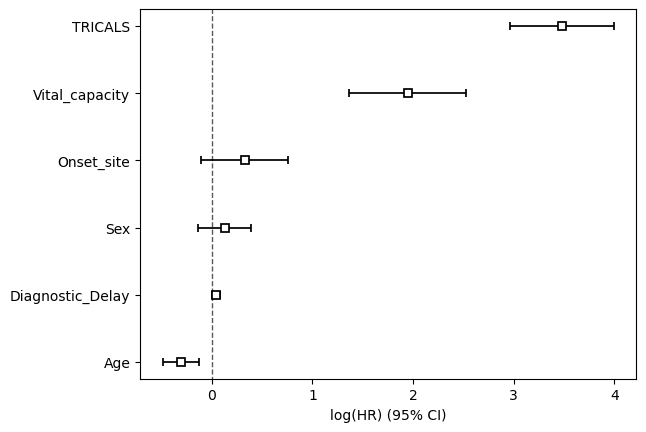

In [62]:
cph.plot()

In [63]:
# Check model performance on test set
from lifelines.utils import concordance_index

# Predict partial hazards (risk scores) on test set
test_pred = cph.predict_partial_hazard(test_dff)

# Concordance Index
c_index = concordance_index(
    event_times=test_dff["Disease_Duration"],
    predicted_scores=-test_pred,   # negative, because higher hazard = higher risk
    event_observed=test_dff["Event"]
)

print("C-index on test set:", c_index)


C-index on test set: 0.9187279151943463


In [64]:
# train_df = train_df.drop(columns='Study_Arm')

In [65]:
train_dff.columns

Index(['Vital_capacity', 'Diagnostic_Delay', 'Age', 'TRICALS', 'Onset_site',
       'European', 'Sex', 'Sex_onset_limb', 'Age_onset_limb',
       'Disease_Duration', 'Event'],
      dtype='object')

##### **Simulating vitual placebo arm**

In [66]:
# train_cov = train_df[['Age.', 'TRICALS.','ALSFRS_Rasch.', 'Diagnosis_delay.', 'Sex_Male',
#                       'Onset_site_limb', 'Onset_site_other','Riluzole_use_Yes','European_1.0',
#                      'Sex_onset_other', 'Sex_onset_limb','Sex_Riluzole','Trical_Riluzole']]

## ***Compute prognostic score (centered at mean)***

#### ***Training set***

In [68]:
betas = cph.params_

cov_centered = train_dff[betas.index] - train_dff[betas.index].mean()

train_dff['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
train_dff['relative_hazard'] = np.exp(train_dff['prognostic_score'])

# Categorize prognostic score
train_dff['risk'] = np.where(train_dff['prognostic_score'] < train_dff['prognostic_score'].median(), 1, 0)

In [69]:
betas

covariate
Vital_capacity      1.944516
Diagnostic_Delay    0.040084
Age                -0.306887
Sex                 0.128681
TRICALS             3.477017
Onset_site          0.326042
Name: coef, dtype: float64

In [70]:
train_dff.head()
# train_df[betas.index].mean()

,Vital_capacity,Diagnostic_Delay,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb,Disease_Duration,Event,prognostic_score,relative_hazard,risk
1318,4.173686,0.032852,-0.319549,0.647559,1,1,0,0,-0.319549,9.954008,1,2.150234,8.586871,0
537,4.319275,12.976347,0.219544,-0.110204,1,1,1,1,0.219544,19.809461,1,0.280648,1.323987,1
1465,4.264645,0.229961,0.938334,1.252487,1,1,1,1,0.938334,2.299606,1,4.181002,65.431369,0
1602,3.968872,0.000000,0.489090,1.108693,1,1,1,1,0.489090,4.796321,1,3.234542,25.394729,0
238,4.532599,4.464000,1.218034,-0.609858,0,1,1,0,0.000000,25.980967,0,-2.015520,0.133251,1


In [ ]:
# train_dff.risk.value_counts()

In [71]:
# crosstab = pd.crosstab(train_dff['Event'], train_dff['risk'])
# print(crosstab)

# crosstab.plot(kind='bar', stacked=True, figsize=(4,3))

##### ***compare the KM curves for 'risk' groups***

In [72]:
train_dff.head(2)

,Vital_capacity,Diagnostic_Delay,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb,Disease_Duration,Event,prognostic_score,relative_hazard,risk
1318,4.173686,0.032852,-0.319549,0.647559,1,1,0,0,-0.319549,9.954008,1,2.150234,8.586871,0
537,4.319275,12.976347,0.219544,-0.110204,1,1,1,1,0.219544,19.809461,1,0.280648,1.323987,1


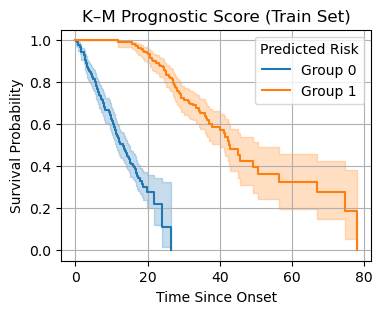

In [73]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(4,3))

for group in train_dff['risk'].unique():
    mask = train_dff['risk'] == group
    kmf.fit(train_dff['Disease_Duration'][mask], event_observed=train_dff['Event'][mask],
            label=f'Group {group}')
    kmf.plot_survival_function(ci_show=True)

plt.title("K–M Prognostic Score (Train Set)")
plt.xlabel("Time Since Onset")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted Risk")
plt.grid(True)
plt.show()

##### ***Statistical comparison between groups Use the log-rank test from lifelines***

In [75]:
from lifelines.statistics import logrank_test

group0 = train_dff[train_dff["risk"] == 0]
group1 = train_dff[train_dff["risk"] == 1]

results = logrank_test(group0["Disease_Duration"], group1["Disease_Duration"],
                       event_observed_A=group0["Event"],
                       event_observed_B=group1["Event"])

print(results.summary)


   test_statistic             p    -log2(p)
0      243.411617  7.093198e-55  179.879609


#### ***Test Set***

In [76]:
# Test set
betas = cph.params_

cov_centered = test_dff[betas.index] - test_dff[betas.index].mean()

test_dff['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
test_dff['relative_hazard'] = np.exp(test_dff['prognostic_score'])

# Categorize prognostic score
test_dff['risk'] = np.where(test_dff['prognostic_score'] < test_dff['prognostic_score'].median(), 1, 0)
test_dff.head(2)

,Vital_capacity,Diagnostic_Delay,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb,Disease_Duration,Event,prognostic_score,relative_hazard,risk
1523,3.145694,1.084100,-0.948491,2.009037,1,1,1,1,-0.948491,7.063075,1,5.445812,231.785356,0
135,4.276666,14.527595,0.293341,-0.519267,1,1,1,1,0.293341,33.527595,0,-0.988183,0.372252,1


In [77]:
# crosstab = pd.crosstab(test_dff['Event'], test_dff['risk'])
# print(crosstab)

# crosstab.plot(kind='bar', stacked=True, figsize=(4,3))

##### ***compare the KM curves for 'risk' groups***

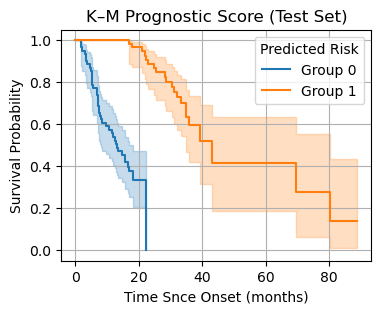

In [78]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(4,3))

for group in test_dff['risk'].unique():
    mask = test_dff['risk'] == group
    kmf.fit(test_dff['Disease_Duration'][mask], event_observed=test_dff['Event'][mask],
            label=f'Group {group}')
    kmf.plot_survival_function(ci_show=True)

plt.title("K–M Prognostic Score (Test Set)")
plt.xlabel("Time Snce Onset (months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted Risk")
plt.grid(True)
plt.show()

##### ***Statistical comparison between groups Use the log-rank test from lifelines***

In [80]:
from lifelines.statistics import logrank_test

group0 = test_df[test_dff["risk"] == 0]
group1 = test_df[test_dff["risk"] == 1]

results = logrank_test(group0["Disease_Duration"], group1["Disease_Duration"],
                       event_observed_A=group0["Event"],
                       event_observed_B=group1["Event"])

print(results.summary)


   test_statistic             p   -log2(p)
0       58.889757  1.667580e-14  45.769237


## ***Estimate Survival Time***

##### ***For training data***

In [82]:

surv_func = cph.predict_survival_function(train_dff[betas.index])
# print(surv_func)

# plt.figure(figsize=(3,2))
# surv_func.plot()
# plt.title("Predicted Survival Curve for New Patient")
# plt.xlabel("Time")
# plt.ylabel("Survival Probability")
# plt.show()

median_survival_time = []
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
        # fall back: take the maximum available time in the grid
        median_time = surv_curve.median()
        # median_time = surv_curve.index.max()
    median_survival_time.append(median_time)

train_dff['median_survival_time'] = median_survival_time
train_dff.head(2)

,Vital_capacity,Diagnostic_Delay,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb,Disease_Duration,Event,prognostic_score,relative_hazard,risk,median_survival_time
1318,4.173686,0.032852,-0.319549,0.647559,1,1,0,0,-0.319549,9.954008,1,2.150234,8.586871,0,16.605782
537,4.319275,12.976347,0.219544,-0.110204,1,1,1,1,0.219544,19.809461,1,0.280648,1.323987,1,24.915900


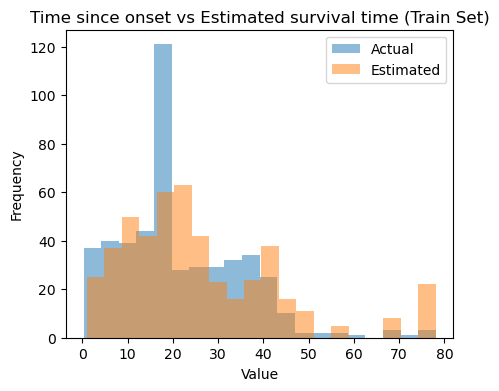

In [83]:
# Compare distributions
plt.figure(figsize=(5,4))
plt.hist(train_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(train_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Time since onset vs Estimated survival time (Train Set)")
plt.legend()
plt.show()

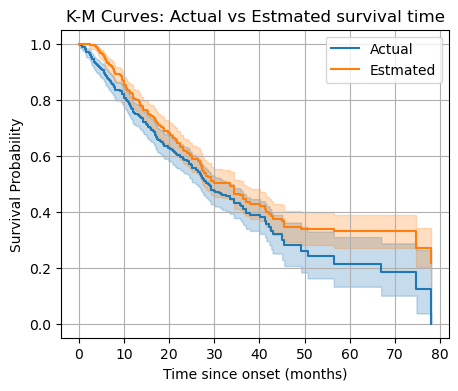

In [87]:
# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(train_dff['Disease_Duration'], event_observed=train_dff['Event'], label='Actual')

# Simulated data
km_sim1 = KaplanMeierFitter()
km_sim1.fit(train_dff['median_survival_time'], event_observed=train_dff['Event'], label='Estmated')

# # Simulated data
# km_sim2 = KaplanMeierFitter()
# km_sim2.fit(df_sim['time'], event_observed=df_sim['event'], label='Simulated event')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim1.plot()
# km_sim2.plot()
plt.title('K-M Curves: Actual vs Estmated survival time')
plt.xlabel('Time since onset (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [85]:
# fig, axes = plt.subplots(1, 2, figsize=(6,4), sharey=True)

# km = KaplanMeierFitter()

# # Original Survival time (disease duration)
# km.fit(train_df['Disease_Duration'], event_observed=train_df['Event'], label='Actual')
# km.plot_survival_function(ax=axes[0])
# axes[0].set_title("KM Curve")
# axes[0].set_xlabel("Time since onset (Actual)")
# axes[0].set_ylabel("Survival probability")

# # Estimated Survival time 
# km.fit(train_df['median_survival_time'], event_observed=train_df['Event'], label='Estmated')
# km.plot_survival_function(ax=axes[1])
# axes[1].set_title("KM Curve")
# axes[1].set_xlabel("Time since onset (Estimated)")

# plt.tight_layout()
# plt.show()

##### ***For test data***

In [88]:
surv_func = cph.predict_survival_function(test_dff[betas.index])
# print(surv_func)

# plt.figure(figsize=(3,2))
# surv_func.plot()
# plt.title("Predicted Survival Curve for New Patient")
# plt.xlabel("Time")
# plt.ylabel("Survival Probability")
# plt.show()

median_survival_time = []
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
        # fall back: take the maximum available time in the grid
        median_time = surv_curve.median()
        # median_time = surv_curve.index.max()
    median_survival_time.append(median_time)

test_dff['median_survival_time'] = median_survival_time
test_dff.head(3)

,Vital_capacity,Diagnostic_Delay,Age,TRICALS,Onset_site,European,Sex,Sex_onset_limb,Age_onset_limb,Disease_Duration,Event,prognostic_score,relative_hazard,risk,median_survival_time
1523,3.145694,1.084100,-0.948491,2.009037,1,1,1,1,-0.948491,7.063075,1,5.445812,231.785356,0,2.431012
135,4.276666,14.527595,0.293341,-0.519267,1,1,1,1,0.293341,33.527595,0,-0.988183,0.372252,1,29.960578
451,4.551367,16.951380,0.848486,-0.530997,0,1,0,0,0.000000,28.153745,1,-1.022741,0.359608,1,30.157687


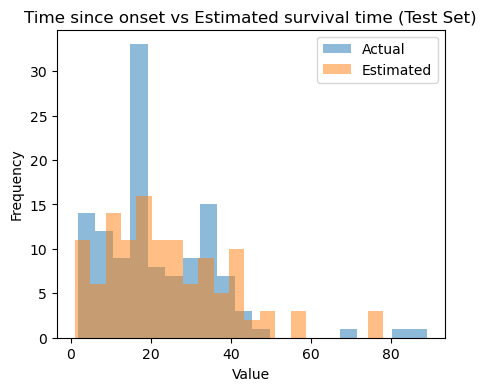

In [89]:
# Compare distributions
plt.figure(figsize=(5,4))
plt.hist(test_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(test_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated')
# plt.hist(np.log1p(test_dff['median_survival_time']), bins=20, alpha=0.5, label='Estimated2')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Time since onset vs Estimated survival time (Test Set)")
plt.legend()
plt.show()

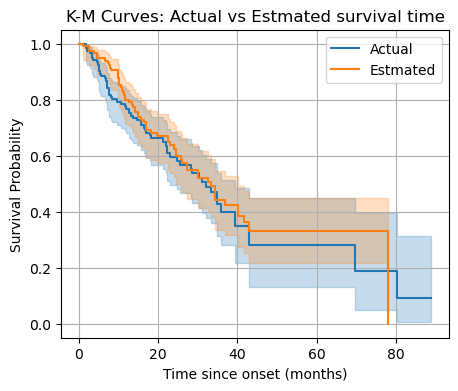

In [90]:
# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(test_dff['Disease_Duration'], event_observed=test_dff['Event'], label='Actual')

# Simulated data
km_sim1 = KaplanMeierFitter()
km_sim1.fit(test_dff['median_survival_time'], event_observed=test_dff['Event'], label='Estmated')

# # Simulated data
# km_sim2 = KaplanMeierFitter()
# km_sim2.fit(df_sim['time'], event_observed=df_sim['event'], label='Simulated event')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim1.plot()
# km_sim2.plot()
plt.title('K-M Curves: Actual vs Estmated survival time')
plt.xlabel('Time since onset (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [91]:
# fig, axes = plt.subplots(1, 2, figsize=(6,4), sharey=True)

# km = KaplanMeierFitter()

# # Original Survival time (disease duration)
# km.fit(test_df['Disease_Duration'], event_observed=test_df['Event'], label='Actual')
# km.plot_survival_function(ax=axes[0])
# axes[0].set_title("KM Curve")
# axes[0].set_xlabel("Time since onset (Actual)")
# axes[0].set_ylabel("Survival probability")


# # Estimated Survival time 
# km.fit(test_df['median_survival_time'], event_observed=test_df['Event'], label='Estmated')
# km.plot_survival_function(ax=axes[1])
# axes[1].set_title("KM Curve")
# axes[1].set_xlabel("Time since onset (Estimated)")

# plt.tight_layout()
# plt.show()


## ***Simulate Virtual Placebo***

In [92]:
def simulate_cox_dataset(n,
                         baseline='weibull',
                         lam=0.1,
                         rho=1.0,
                         censor_rate = 0.3,
                         seed=None,
                         var_specs=None):
    """
    Simulate survival times under a cox proportional hazards model with mixed covariates.

    Parameters
    __________
    n: int = Number of observations.
    baseliine: str = exponential or weibull baseline hazard.
    lam: float = Baseline hazard parameter.
    rho: float = Shape parameter for weibull (ignore if exponential).
    censor_rate: float = Approximate censoring proportion.
    seed: int or None: Random seed.
    var_specs: list of dicts
        Each dict describes a variable. Example:
        {'name': 'age', 'type': 'continuous', 'dist': {'kind': 'normal', 'mean': 50, 'sd':10},
          'coef':0.02}
        {'name': 'sex', 'type': 'binary', 'prob':0.5, 'coef':0.3}
        {'name': 'treatment', 'type': 'categorical', 'levels': ['A', 'B', 'C'],
          'probs':[0.4,0.3,0.3], 'coef': {'B': 0.5, 'C':-0.2}, 'ref':'A'}

    Returns: pd.DataFrame = DataFrame with columns; time, event, linear_predictor, and covariates.
    
    """

    rng = np.random.default_rng(seed)
    if var_specs is None:
        raise ValueError('Provide var_specs describing variables and coefficients.')
    
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    for spec in var_specs:
        name = spec['name']
        typ = spec['type'].lower()

        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean':0, 'sd':1})
            if dist['kind'] == 'normal':
                x = rng.normal(loc=dist.get('mean', 0), scale=dist.get('sd', 1), size=n)
            elif dist['kind'] == 'uniform':
                x = rng.uniform(low=dist.get('low',0), high=dist.get('high',1), size=n)
            else:
                raise ValueError('Unsupported continuous dist kind')
            coef = float(spec.get('coef', 0.0))
            df[name] = x
            linear_pred +=coef * x 

        elif typ == 'binary':
            p = float(spec.get('prob',0.5))
            x = rng.binomial(1, p, size=n)
            coef = float(spec.get('coef',0.0))
            df[name] = x.astype(int)
            linear_pred += coef * x 

        elif typ == 'categorical':
            levels = list(spec.get('levels'))
            probs = spec.get('probs', [1/len(levels)]*len(levels))
            cats = rng.choice(levels, size=n, p=probs)
            df[name] = pd.Categorical(cats, categories=levels)
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                lvl_coef = float(coef_map.get(lvl, 0.0))
                linear_pred += lvl_coef * (cats == lvl)
        else:
            raise ValueError('Unsupported variable type: ' + typ)
        
    # Generate survival times via inverse transform
    U = rng.uniform(size=n)
    if baseline == 'exponential' or rho == 1.0:
        T = -np.log(U) / (lam * np.exp(linear_pred))
    elif baseline == 'weibull':
        T = ((-np.log(U))) / (lam * np.exp(linear_pred)) ** (1.0/ rho)
    else:
        raise ValueError('Unsupported baseline: ' + baseline)
    
    # Generate censoring times (exponential heuristic)
    censor_rate = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=censor_rate, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor'] + [c for c in df.columns if c not in ['time', 'event', 'true_survival_time', 'linear_predictor']]
    df = df[cols]
    return df

In [93]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm',
       'Diagnostic_Delay', 'Disease_Duration', 'Study_id', 'Expt', 'Age',
       'TRICALS', 'Onset_site', 'European', 'Sex', 'Sex_onset_limb',
       'Age_onset_limb'],
      dtype='object')

In [95]:
print(df.Event.value_counts() / df.Event.value_counts().sum())
print(df.Onset_site.value_counts() / df.Onset_site.value_counts().sum())
print(df.Sex.value_counts() / df.Sex.value_counts().sum())
print(df.European.value_counts() / df.European.value_counts().sum())
# print(df.Riluzole_use.value_counts() / df.Riluzole_use.value_counts().sum())

print(f'Age: {df['Age'].mean():.2f}, {df['Age'].std():.2f}')
print(f'TRICALS: {df['TRICALS'].mean():.2f}, {df['TRICALS'].std():.2f}')
# print(f'ALSFRS_Rasch: {df['ALSFRS_Rasch'].mean():.2f}, {df['ALSFRS_Rasch'].std():.2f}')
print(f'Diagnostic_Delay: {df['Diagnostic_Delay'].mean():.2f}, {df['Diagnostic_Delay'].std():.2f}')

Event
1    0.510779
0    0.489221
Name: count, dtype: float64
Onset_site
1    0.849088
0    0.150912
Name: count, dtype: float64
Sex
1    0.618574
0    0.381426
Name: count, dtype: float64
European
1    0.986733
0    0.013267
Name: count, dtype: float64
Age: 0.05, 1.03
TRICALS: -0.17, 1.13
Diagnostic_Delay: 7.79, 11.67


In [96]:
betas

covariate
Vital_capacity      1.944516
Diagnostic_Delay    0.040084
Age                -0.306887
Sex                 0.128681
TRICALS             3.477017
Onset_site          0.326042
Name: coef, dtype: float64

In [97]:
betas['Vital_capacity']

np.float64(1.9445158103593347)

In [99]:
ons = df.Onset_site.value_counts() / df.Onset_site.value_counts().sum()
sex = df.Sex.value_counts() / df.Sex.value_counts().sum()

In [100]:
ons[1]
sex[1]

np.float64(0.6185737976782753)

In [126]:
train_dff.shape

(482, 15)

In [127]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':betas['Age']},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':betas['TRICALS']},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':df['Diagnostic_Delay'].mean(),
                                                           'sd':df['Diagnostic_Delay'].std()},
                                                           'coef':betas['Diagnostic_Delay']},
    {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':df['Vital_capacity'].mean(),
                                                           'sd':df['Vital_capacity'].std()},
                                                           'coef':betas['Vital_capacity']},

    # binary
    {'name':'Sex','type':'binary','prob':sex[1],'coef':betas['Sex']},
    {'name':'Onset_site','type':'binary','prob':ons[1],'coef':betas['Onset_site']}
    
    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
    
    # interactions not included yet!
]

df_sim = simulate_cox_dataset(n=train_dff.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
                              censor_rate=0.3, seed=42, var_specs=var_specs_real)

df_sim.head(3)


,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Sex,Onset_site
0,0.036051,1,0.036051,10.936426,0.304717,0.091520,7.377621,5.122753,1,1
1,0.010593,1,0.010593,11.939857,-1.039984,0.580777,-8.127359,4.871333,1,1
2,0.315173,1,0.315173,8.590911,0.750451,-0.056783,4.808629,4.305019,1,1


In [128]:
# Identify categorical columns
# cat_sim = ['Onset_site']  # replace with your actual categorical columns

# One-hot encode
# sim_onehot = pd.get_dummies(df_sim, columns=cat_sim, drop_first=True)
sim_onehot = df_sim

# sim_onehot['Onset_site_limb'] = sim_onehot['Onset_site_limb'].astype(int)

# # Create interactions
# sim_onehot['Sex_onset_limb'] = sim_onehot['Sex_Male']*sim_onehot['Onset_site_limb']

# sim_onehot['Sex_Riluzole'] = sim_onehot['Sex_Male']*sim_onehot['Riluzole_use_Yes']
# sim_onehot['Trical_Riluzole'] = sim_onehot['TRICALS']*sim_onehot['Riluzole_use_Yes']
# sim_onehot['Age_Riluzole'] = sim_onehot['Age']*sim_onehot['Riluzole_use_Yes']

sim_onehot.head(3)


,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Sex,Onset_site
0,0.036051,1,0.036051,10.936426,0.304717,0.091520,7.377621,5.122753,1,1
1,0.010593,1,0.010593,11.939857,-1.039984,0.580777,-8.127359,4.871333,1,1
2,0.315173,1,0.315173,8.590911,0.750451,-0.056783,4.808629,4.305019,1,1


In [129]:
# Simulated prognostic score
betas = cph.params_

cov_centered = sim_onehot[betas.index] - sim_onehot[betas.index].mean()

sim_onehot['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
sim_onehot['relative_hazard'] = np.exp(sim_onehot['prognostic_score'])

# Categorize prognostic score
sim_onehot['risk'] = np.where(sim_onehot['prognostic_score'] < sim_onehot['prognostic_score'].mean(), 1, 0)
sim_onehot.head(2)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Sex,Onset_site,prognostic_score,relative_hazard,risk
0,0.036051,1,0.036051,10.936426,0.304717,0.091520,7.377621,5.122753,1,1,1.994808,7.350791,0
1,0.010593,1,0.010593,11.939857,-1.039984,0.580777,-8.127359,4.871333,1,1,2.998239,20.050193,0


In [130]:
sim_onehot.risk.value_counts()

risk
0    248
1    234
Name: count, dtype: int64

In [131]:
# Survival time for simulated patients
surv_func = cph.predict_survival_function(sim_onehot[betas.index])

median_survival_time = []
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
        # fall back: take the maximum available time in the grid
        median_time = surv_curve.median()
    median_survival_time.append(median_time)

sim_onehot['median_survival_time'] = median_survival_time
sim_onehot.head(2)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Sex,Onset_site,prognostic_score,relative_hazard,risk,median_survival_time
0,0.036051,1,0.036051,10.936426,0.304717,0.091520,7.377621,5.122753,1,1,1.994808,7.350791,0,15.212084
1,0.010593,1,0.010593,11.939857,-1.039984,0.580777,-8.127359,4.871333,1,1,2.998239,20.050193,0,8.114323


In [132]:
train_dff.shape

(482, 15)

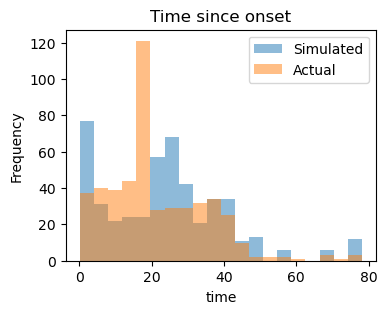

In [133]:
# Compare distributions
plt.figure(figsize=(4,3))
# plt.hist(train_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(sim_onehot['median_survival_time'], bins=20, alpha=0.5, label='Simulated')
plt.hist(train_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')

plt.xlabel("time")
plt.ylabel("Frequency")
plt.title("Time since onset")
plt.legend()
plt.show()

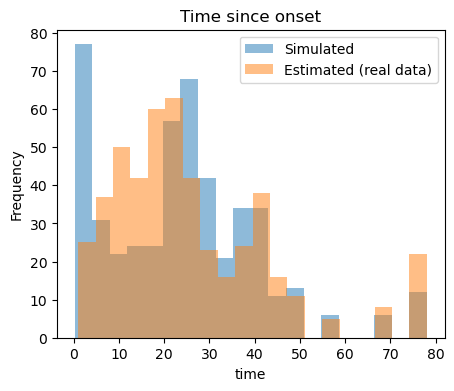

In [134]:
# Compare distributions
plt.figure(figsize=(5,4))
# plt.hist(train_df['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(sim_onehot['median_survival_time'], bins=20, alpha=0.5, label='Simulated')
plt.hist(train_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated (real data)')

plt.xlabel("time")
plt.ylabel("Frequency")
plt.title("Time since onset")
plt.legend()
plt.show()

In [135]:
# sim_onehot.describe(include='all')

In [136]:
# train_df.describe(include='all')

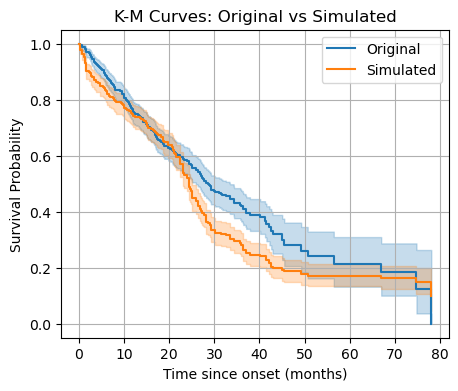

In [137]:
# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(train_dff['Disease_Duration'], event_observed=train_dff['Event'], label='Original')

# Simulated data
km_sim1 = KaplanMeierFitter()
km_sim1.fit(sim_onehot['median_survival_time'], event_observed=sim_onehot['event'], label='Simulated')

# # Simulated data
# km_sim2 = KaplanMeierFitter()
# km_sim2.fit(df_sim['time'], event_observed=df_sim['event'], label='Simulated event')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim1.plot()
# km_sim2.plot()
plt.title('K-M Curves: Original vs Simulated')
plt.xlabel('Time since onset (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [138]:
# train_df1 = train_df[['Event', 'Disease_Duration','Age.', 'TRICALS.','ALSFRS_Rasch.',
#                       'Diagnosis_delay.', 'Onset_site_limb', 'Onset_site_other', 
#                       'Riluzole_use_Yes','European_1.0', 'Sex_Male']]

In [139]:
# # Fit Cox model
# cph = CoxPHFitter()
# cph.fit(train_df, duration_col="Disease_Duration", event_col="Event")

# # Simulate new dataset
# sim_df = simulate_from_cox(
#     cph,
#     train_df,
#     n=len(train_df),
#     duration_col="Disease_Duration",
#     event_col="Event",
#     rng_seed=42
# )

# print("Target events:", sim_df.attrs['target_events'])
# print("Simulated events:", sim_df.attrs['simulated_events'])
# sim_df.head()

##### 1. Compare survival distributions

In [140]:
# sim_onehot.median_survival_time.describe()

In [141]:
# train_df.Disease_Durationc.describe()

In [142]:
sim_onehot.risk.value_counts()

risk
0    248
1    234
Name: count, dtype: int64

In [143]:
# Original data
# km_orig = KaplanMeierFitter()
# km_orig.fit(train_df['Disease_Duration'], event_observed=train_df['Event'], label='Original')

# # Simulated data
# km_sim = KaplanMeierFitter()
# km_sim.fit(sim_onehot['median_survival_time'], event_observed=sim_onehot['event'], label='Simulated')

# # Plot together
# plt.figure(figsize=(5,4))
# km_orig.plot()
# km_sim.plot()
# plt.title('Kaplan-Meier Curves: Original vs Simulated')
# plt.xlabel('Disease Duration (months)')
# plt.ylabel('Survival Probability')
# plt.grid(True)
# plt.show()


##### 2. Compare covariate distributions

In [144]:
sim_onehot.columns

Index(['time', 'event', 'true_survival_time', 'linear_predictor', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Sex', 'Onset_site',
       'prognostic_score', 'relative_hazard', 'risk', 'median_survival_time'],
      dtype='object')

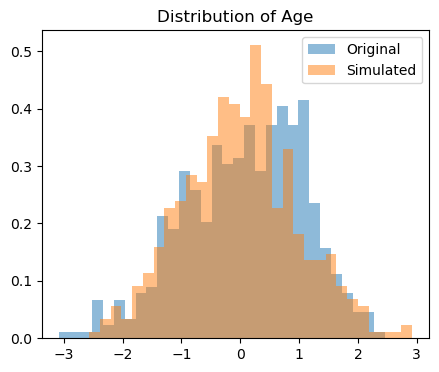

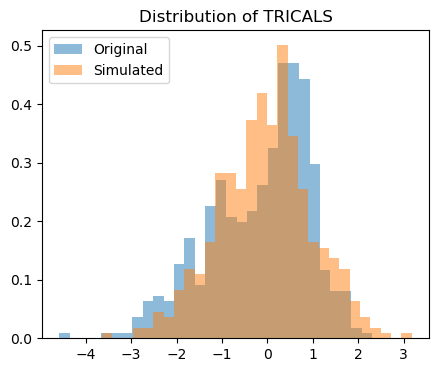

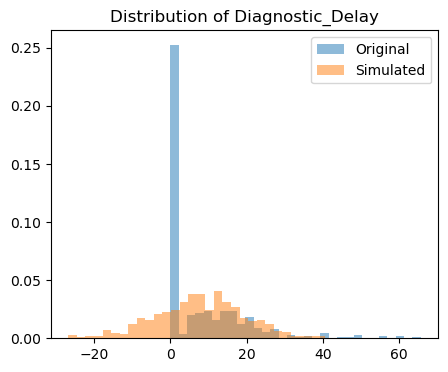

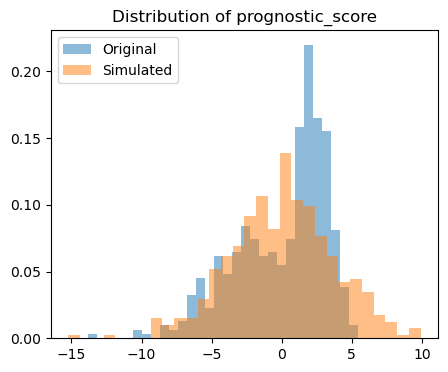

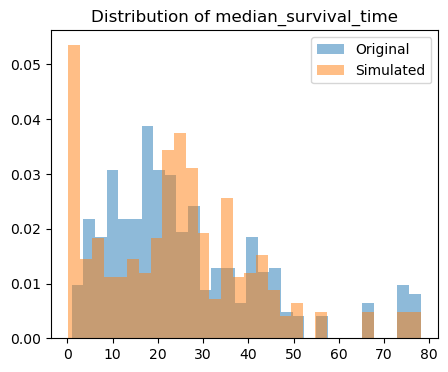

In [145]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay', 'prognostic_score', 'median_survival_time']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(train_df[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_onehot[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()


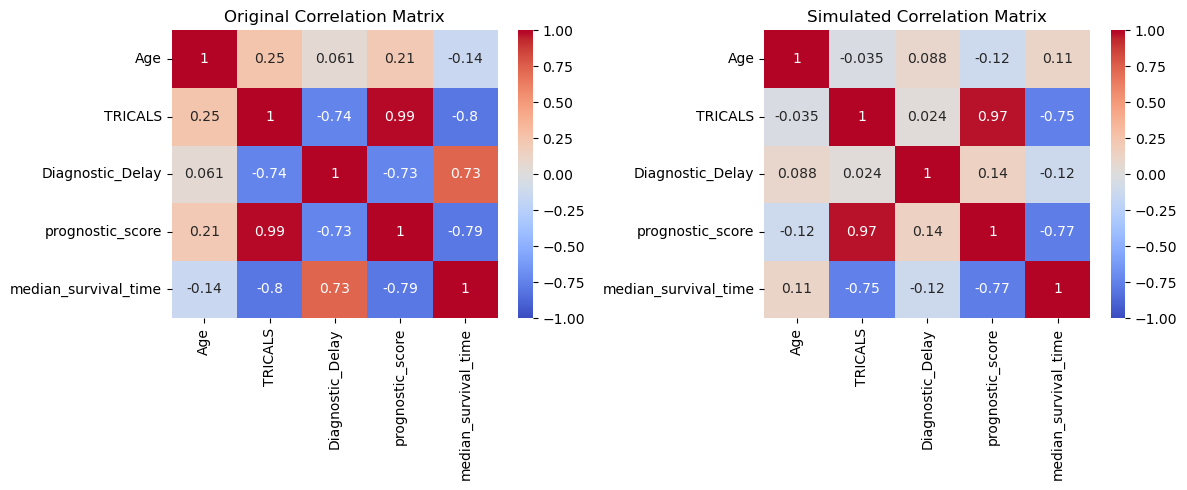

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['Age', 'TRICALS', 'Diagnostic_Delay', 'prognostic_score', 'median_survival_time']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(train_dff[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_onehot[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()


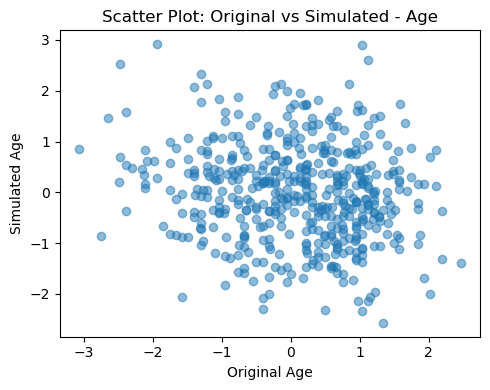

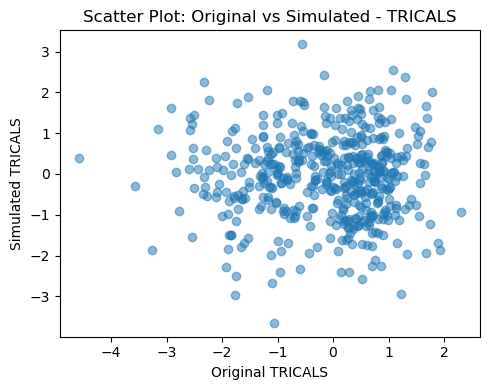

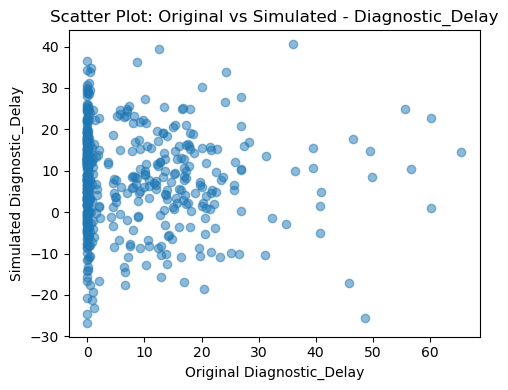

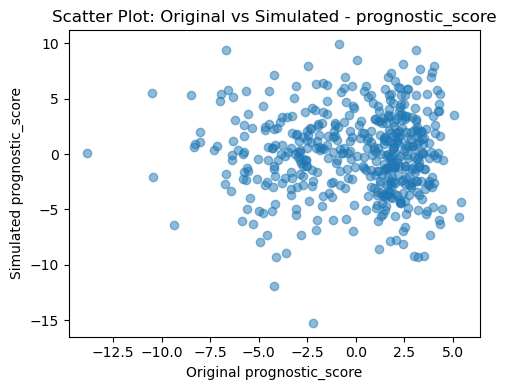

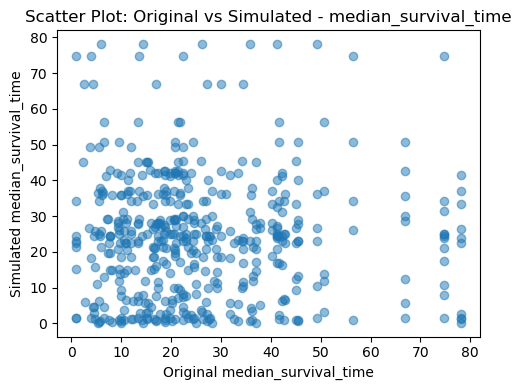

In [147]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay', 'prognostic_score', 'median_survival_time']:  
    plt.figure(figsize=(5,4))

    plt.scatter(train_dff[col], sim_onehot[col], alpha=0.5)

    plt.xlabel(f'Original {col}')
    plt.ylabel(f'Simulated {col}')
    plt.title(f'Scatter Plot: Original vs Simulated - {col}')

    plt.tight_layout()
    plt.show()


In [121]:
# categorical_cols = ['Onset_site_limb', 'Riluzole_use_Yes', 'European_1', 'Sex_Male', 
#        'Sex_onset_limb', 'Sex_Riluzole']  # your categorical columns

# for col in categorical_cols:
#     # Compute normalized value counts
#     orig_counts = train_df[col].value_counts(normalize=True).sort_index()
#     sim_counts = sim_onehot[col].value_counts(normalize=True).reindex(orig_counts.index, fill_value=0)

#     # Setup bar positions
#     x = np.arange(len(orig_counts))
#     width = 0.35

#     # Plot bars
#     fig, ax = plt.subplots(figsize=(5,4))
#     ax.bar(x - width/2, orig_counts.values, width, label='Original', color='skyblue')
#     ax.bar(x + width/2, sim_counts.values, width, label='Simulated', color='salmon')

#     # Labels and title
#     ax.set_xticks(x)
#     ax.set_xticklabels(orig_counts.index, rotation=45)
#     ax.set_ylabel('Proportion')
#     ax.set_title(f'Comparison of {col}: Original vs Simulated')
#     ax.legend()

#     plt.tight_layout()
#     plt.show()



##### 3. Check event proportions

In [148]:
print("Original events:", train_dff['Event'].sum(), " / ", len(train_df))
print("Simulated events:", sim_onehot['event'].sum(), " / ", len(sim_onehot))

Original events: 248  /  482
Simulated events: 368  /  482


##### 4. Compare Cox model coefficients

In [150]:
sim_onehot.columns

Index(['time', 'event', 'true_survival_time', 'linear_predictor', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Sex', 'Onset_site',
       'prognostic_score', 'relative_hazard', 'risk', 'median_survival_time'],
      dtype='object')

In [151]:
betas.to_dict()

{'Vital_capacity': 1.9445158103593347,
 'Diagnostic_Delay': 0.04008418329865511,
 'Age': -0.3068865918383854,
 'Sex': 0.12868116689771228,
 'TRICALS': 3.4770171195871007,
 'Onset_site': 0.32604177495882564}

In [152]:
# sim_onehot1 = sim_onehot[['Age','TRICALS', 'ALSFRS_Rasch', 'Diagnosis_delay', 'Sex_Male','Height',
#        'Riluzole_use_Yes', 'European_1', 'Onset_site_limb','Sex_onset_limb', 'Sex_Riluzole',
#        'Trical_Riluzole', 'event', 'median_survival_time']]

In [153]:
sim_onehot1 = sim_onehot[betas.index.tolist() + ['event', 'median_survival_time']]
sim_onehot1.head(2)

,Vital_capacity,Diagnostic_Delay,Age,Sex,TRICALS,Onset_site,event,median_survival_time
0,5.122753,7.377621,0.304717,1,0.091520,1,1,15.212084
1,4.871333,-8.127359,-1.039984,1,0.580777,1,1,8.114323


In [154]:
# Train / Test split

# Separate features from survival info
X = sim_onehot1.drop(columns=['median_survival_time', 'event'])
y_duration = sim_onehot1['median_survival_time']
y_event = sim_onehot1['event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.2, random_state=4
)

# Combine back for lifelines format
simtrain_df = X_train.copy()
simtrain_df['median_survival_time'] = y_duration_train
simtrain_df['event'] = y_event_train

simtest_df = X_test.copy()
simtest_df['median_survival_time'] = y_duration_test
simtest_df['event'] = y_event_test

# print(train_df)
# print(test_df)

/opt/anaconda3/envs/digital_twins_2/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


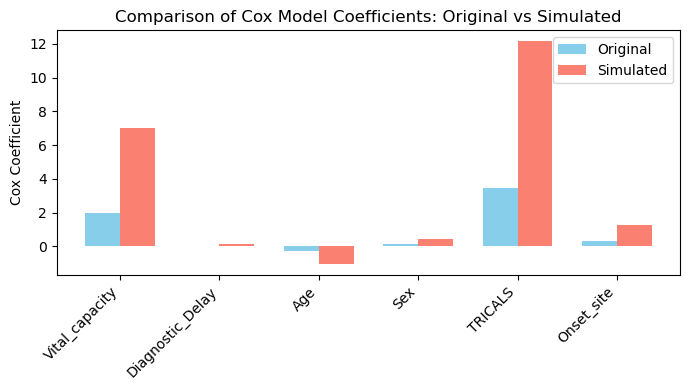

In [155]:
# Fit Cox on simulated data
cph_sim = CoxPHFitter()
cph_sim.fit(simtrain_df, duration_col="median_survival_time", event_col="event")

# Extract coefficients
coeff_orig = cph.params_
coeff_sim = cph_sim.params_

# Align indices (covariates) in case of any mismatch
common_idx = coeff_orig.index.intersection(coeff_sim.index)
coeff_orig = coeff_orig[common_idx]
coeff_sim = coeff_sim[common_idx]

# Plot
x = np.arange(len(common_idx))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width/2, coeff_orig.values, width, label='Original', color='skyblue')
ax.bar(x + width/2, coeff_sim.values, width, label='Simulated', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(common_idx, rotation=45, ha='right')
ax.set_ylabel('Cox Coefficient')
ax.set_title('Comparison of Cox Model Coefficients: Original vs Simulated')
ax.legend()
plt.tight_layout()
plt.show()

In [156]:
# coeff_sim

##### 5. Optional: Compare survival curves stratified by covariates

In [157]:
# for group in train_df['Sexx_Male'].unique():
#     km_orig.fit(train_df.loc[train_df['Sexx_Male']==group, 'Disease_Duration'],
#                 event_observed=train_df.loc[train_df['Sexx_Male']==group, 'Event'], label=f'Original-{group}')
#     km_sim.fit(sim_df.loc[sim_df['Sexx_Male']==group, 'Disease_DurationM'],
#                event_observed=sim_df.loc[sim_df['Sexx_Male']==group, 'Event'], label=f'Simulated-{group}')
#     plt.figure()
#     km_orig.plot()
#     km_sim.plot()
#     plt.title(f'Survival by Sexx_Male={group}')
#     plt.grid(True)
#     plt.show()

##### Compare survival distributions of original active and original placebo

In [158]:
df_pla = df_onehot[df_onehot['Study_Arm'] == 'Placebo']
df_act = df_onehot[df_onehot['Study_Arm'] == 'Active']

In [159]:
print(df_pla.shape, df_act.shape)

(603, 15) (1075, 15)


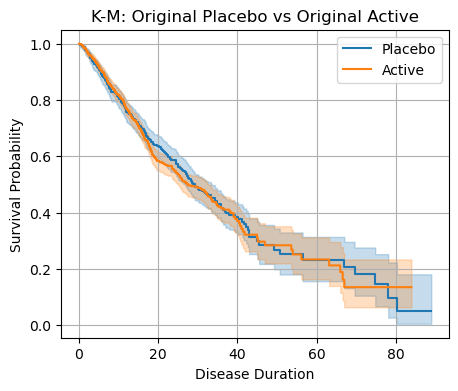

In [160]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(df_pla['Disease_Duration'], event_observed=df_pla['Event'], label='Placebo')

# Simulated data
km_sim = KaplanMeierFitter()
km_sim.fit(df_act['Disease_Duration'], event_observed=df_act['Event'], label='Active')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim.plot()
plt.title('K-M: Original Placebo vs Original Active')
plt.xlabel('Disease Duration')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


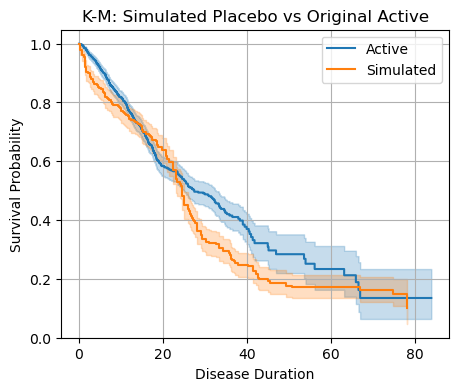

In [161]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Original data
km_orig = KaplanMeierFitter()
km_orig.fit(df_act['Disease_Duration'], event_observed=df_act['Event'], label='Active')

# Simulated data
km_sim = KaplanMeierFitter()
km_sim.fit(sim_onehot['median_survival_time'], event_observed=sim_onehot['event'], label='Simulated')

# Plot together
plt.figure(figsize=(5,4))
km_orig.plot()
km_sim.plot()
plt.title('K-M: Simulated Placebo vs Original Active')
plt.xlabel('Disease Duration')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [162]:
train_df.columns
betas.index

Index(['Vital_capacity', 'Diagnostic_Delay', 'Age', 'Sex', 'TRICALS',
       'Onset_site'],
      dtype='object', name='covariate')

In [805]:
# miro.isna().sum()